## Analysis of extensions and late returns across media types
This notebook is used to explore possible correlations between the amount of extension and late returns across media types.

Most of the analysis is done with media types with at least 1000 borrowings. (Adjust the `MIN_BORROWINGS_PER_MEDIA_TYPE` variable in `03_data_cleaning.ipynb`)

Initialization
- import all dependencies
- read all borrowings from "borrowings" csv-file

In [59]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from utils import setup_pandas, setup_plotting, log_pearson_spearman

input_file = Path('../dat/processed/borrowings_2019_2025_cleaned.csv')

data_frame = pd.read_csv(
    input_file,
    sep=';',
    quotechar='"',
    encoding='utf-8'
)

print(data_frame.shape)
data_frame.head()

(1888669, 21)


,issue_id,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,...,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer,source_year,late_bool,open_days_leihdauer,max_allowed_open_days,weird_loan
0,56565,2019-01-02 00:00:00,2019-03-06 07:09:36,63.0,1,Nein,0.0,esac,Sachbuch,18143906,...,NaN,9783831904525,NaN,MPA,50.0,2019,False,0.0,56,False
1,56566,2019-01-02 00:00:00,2019-03-06 07:09:38,63.0,1,Nein,0.0,esac,Sachbuch,18184110,...,"Bruschke, Gerhard",9783734205736,NaN,MPA,50.0,2019,False,0.0,56,False
2,56567,2019-01-02 00:00:00,2019-03-06 07:09:31,63.0,1,Nein,0.0,esac,Sachbuch,17202121,...,"Fründt, Hans-Jürgen",9783831730735,NaN,MPA,50.0,2019,False,0.0,56,False
3,56574,2019-01-07 00:00:00,2019-02-09 12:14:54,33.0,0,Nein,0.0,eslfantasy,Belletristik,15138046,...,"Sapkowski, Andrzej",9783423247542,Fantasy,A12,10445.0,2019,False,0.0,28,False
4,1000896,2019-01-08 00:00:00,2019-01-28 11:04:21,20.0,0,Nein,0.0,esach,Sachbuch,18506705,...,NaN,9783742601445,Lernhilfe - Deutsch,MZUL,1000014.0,2019,False,0.0,28,False


## First steps - Overview
First we look at the basic properties of extension across media types

In [60]:
base_table = (
    data_frame
    .assign(
        late=data_frame["Verspätet"] == "Ja",
        has_extension=data_frame["Anzahl_Verlängerungen"] > 0
    )
)

per_media_type_table = (
    base_table
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),
        mean_extensions=("Anzahl_Verlängerungen", "mean"),
        median_extensions=("Anzahl_Verlängerungen", "median"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        pct_with_extension=("has_extension", "mean"),
        late_rate=("late", "mean"),
    )
    .reset_index()
    .assign(
        pct_with_extension=lambda df: (df["pct_with_extension"] * 100).round(2),
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

overall_row = pd.DataFrame([{
    "": "Gesamt",
    "n_loans": base_table["Leihdauer"].size,
    "mean_extensions": base_table["Anzahl_Verlängerungen"].mean(),
    "median_extensions": base_table["Anzahl_Verlängerungen"].median(),
    "max_extensions": base_table["Anzahl_Verlängerungen"].max(),
    "pct_with_extension": base_table["has_extension"].mean(),
    "late_rate": base_table["late"].mean(),
}])

display(per_media_type_table)
display(
    overall_row
    .assign(
        pct_with_extension=lambda df: (df["pct_with_extension"] * 100).round(2),
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
    )
    .style.set_properties(**{"font-weight": "bold" })
)


,Medientyp,n_loans,mean_extensions,median_extensions,max_extensions,pct_with_extension,late_rate
11,Sprachkurse,6261,2.126018,1.0,9,65.15,7.83
7,Konsolenspiel,6939,1.463035,1.0,9,54.79,6.24
2,DVD,243468,1.520085,1.0,22,56.13,5.83
9,Sachbuch,315732,1.792083,1.0,15,62.10,5.37
10,Spiele,17779,1.514877,1.0,10,59.06,5.32
12,Tonie,18206,1.202845,1.0,10,53.64,4.78
3,Fremdsprachige Belletristik,24089,1.420648,1.0,14,57.64,4.56
6,Kinder u. Jugendbuch,623096,1.311430,1.0,15,56.58,4.43
13,Zeitschriften,12058,1.238597,1.0,11,50.41,3.58
5,Kinder u. Jugend-CD,162850,1.231471,1.0,10,54.04,3.00


,,n_loans,mean_extensions,median_extensions,max_extensions,pct_with_extension,late_rate
0,Gesamt,1888669,1.342382,1.000000,22,54.500000,4.210000


There are many extensions in the max_extensions column, and the range across media types is quite large. To visualize the distribution of extensions, we use a bar chart.

We group the number of extensions into the following bins: 1, 2, 3, 4, 5, 6, 7–10, >10.

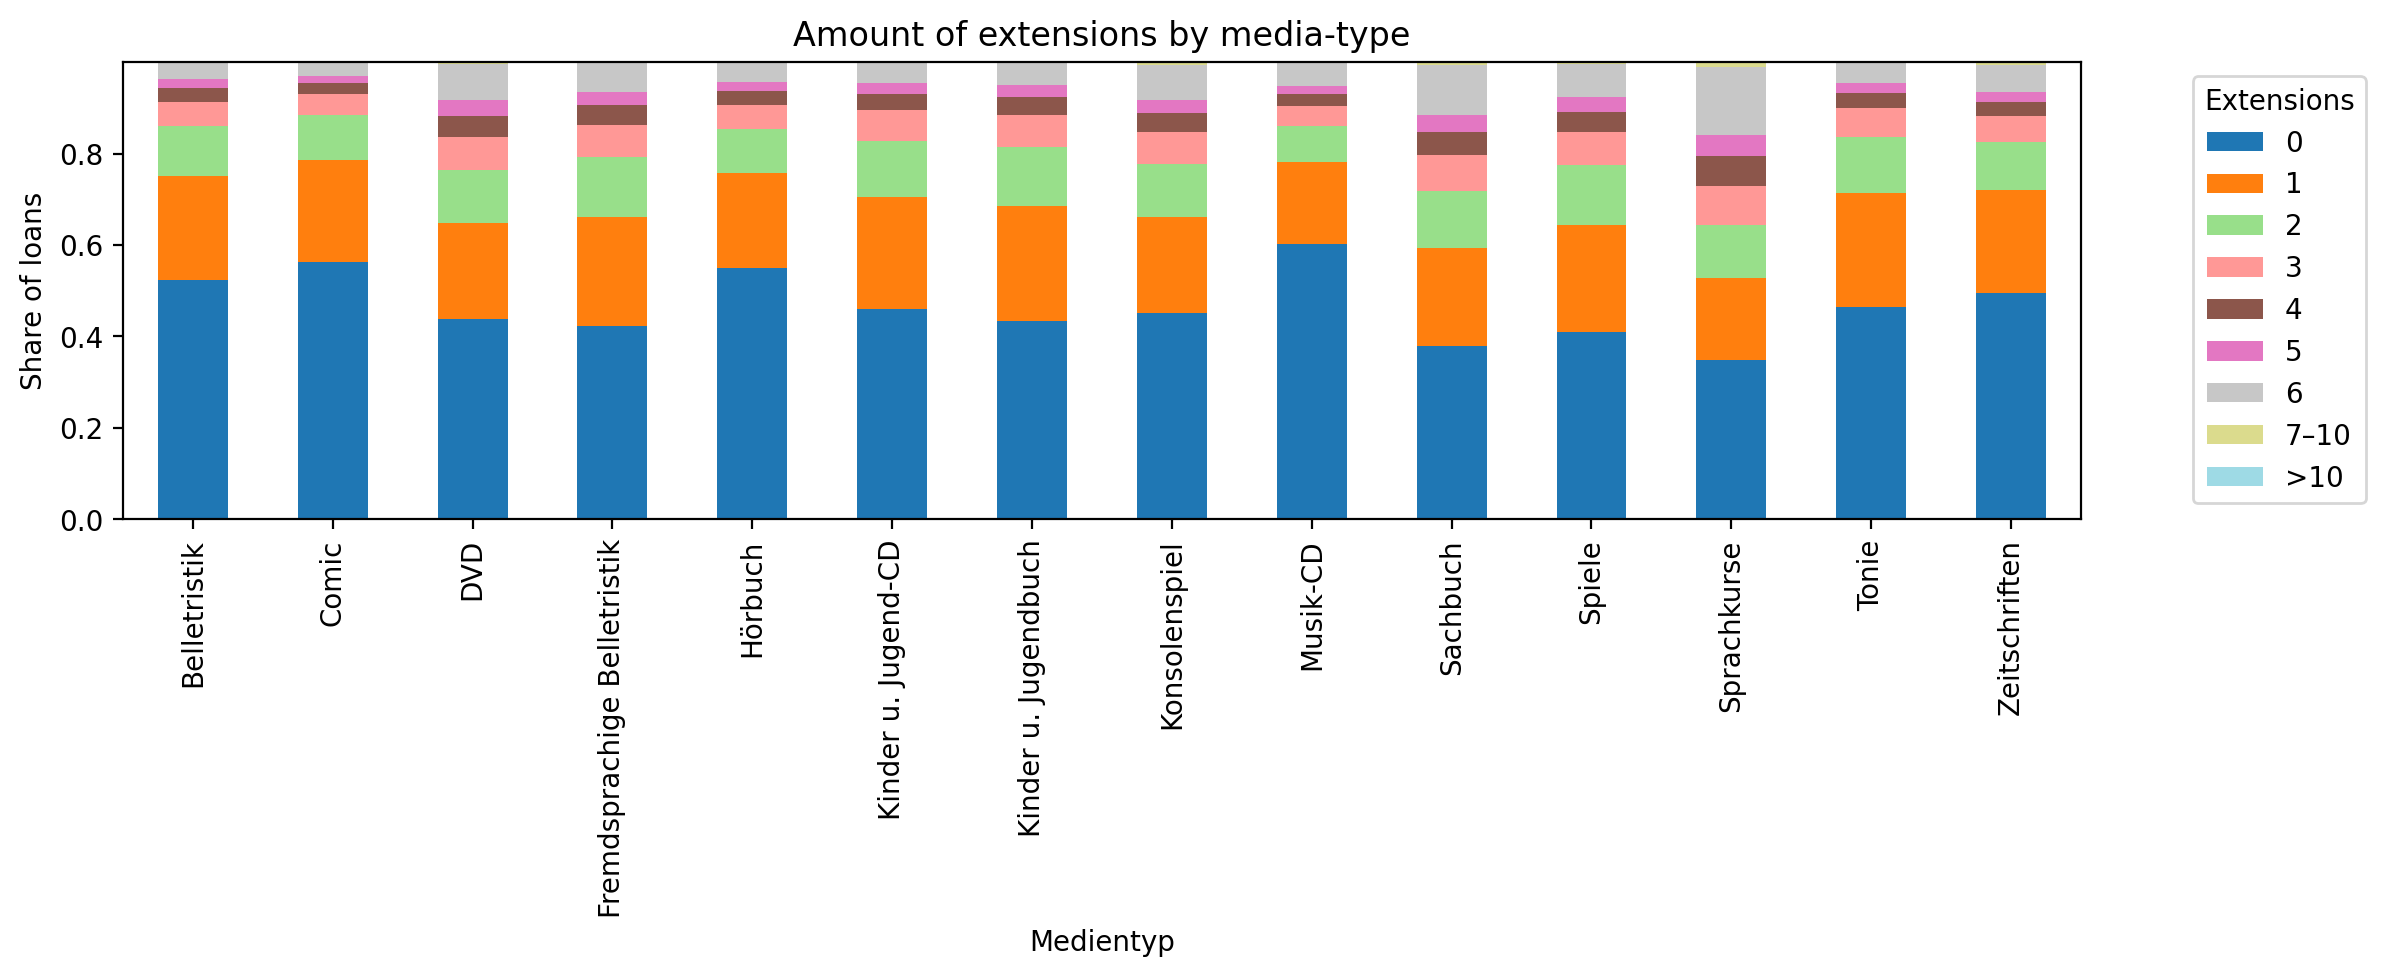

In [61]:
extension_data_frame = data_frame.copy()

# create the bins (cutoff points)
bins   = [-0.1, 0, 1, 2, 3, 4, 5, 6, 10, float("inf")]
labels = ["0", "1", "2", "3", "4", "5", "6", "7–10", ">10"]

# add column for bins
extension_data_frame["extension_bin"] = pd.cut(
    extension_data_frame["Anzahl_Verlängerungen"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)

# count media types per bin
distribution_per_media_type = (
    extension_data_frame
    .groupby(["Medientyp", "extension_bin"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# share per media type
distribution_per_media_type = distribution_per_media_type.div(distribution_per_media_type.sum(axis=1), axis=0)

# bar chart
ax = distribution_per_media_type.plot(kind="bar", stacked=True, figsize=(12, 5), colormap="tab20")
plt.ylabel("Share of loans")
plt.title("Amount of extensions by media-type")
plt.legend(title="Extensions", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


The chart shows that most loans fall into the 1–6 extension bins. Some media types, such as “Sprachkurse,” stand out with comparatively high numbers of extensions. This is likely because language courses are often used over a longer period and require a lot of work and practice, which makes renewals more common.

The next step is to find correlations between extensions and late returns per media type. To get a first impression we look at the late rate and the amount of extensions in a plot.

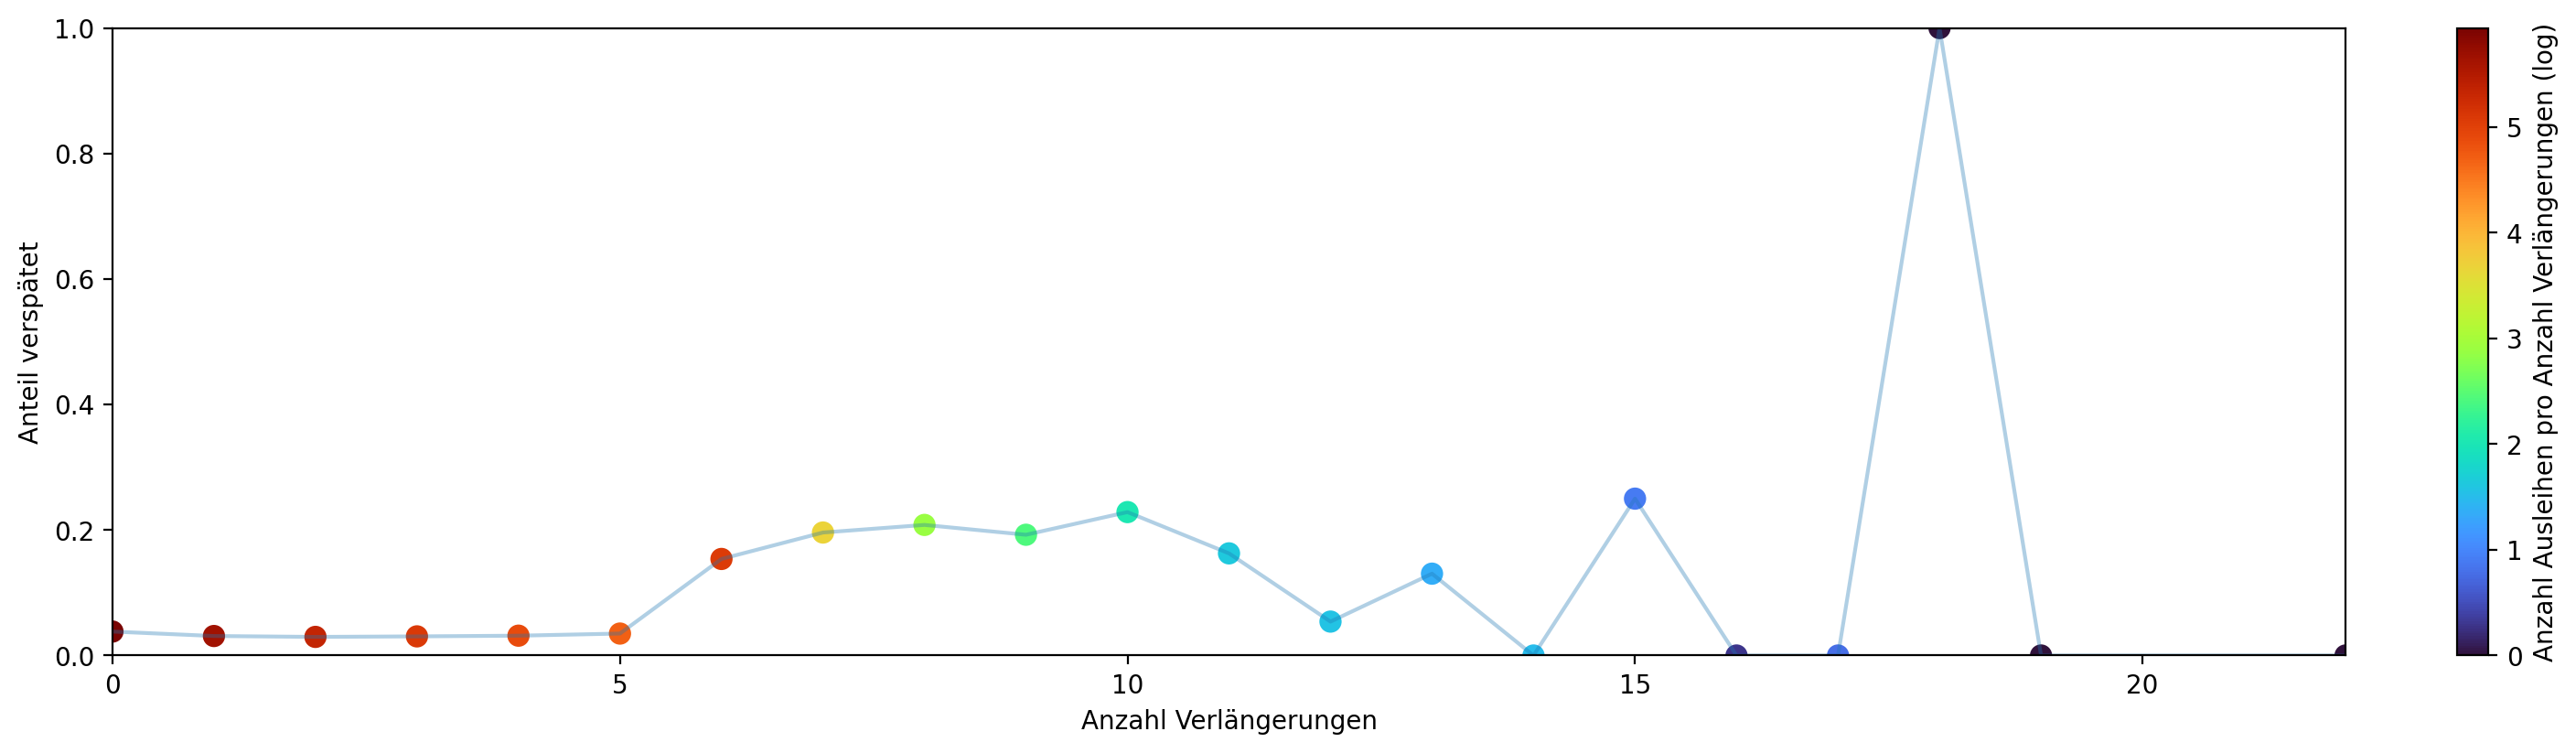

In [62]:
extension_data_frame["late"] = (extension_data_frame["Verspätet"] == "Ja").astype(int)

late_rate_by_extensions = (
    extension_data_frame.groupby("Anzahl_Verlängerungen")["late"]
    .agg(n="size", late_rate="mean")
    .reset_index()
    .sort_values("Anzahl_Verlängerungen")
)

x = late_rate_by_extensions["Anzahl_Verlängerungen"].to_numpy()
y = late_rate_by_extensions["late_rate"].to_numpy()
n = late_rate_by_extensions["n"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

c = np.log10(n)

scatter = ax.scatter(x, y, c=c, s=60, cmap="turbo")
ax.plot(x, y, alpha=0.35)

ax.set_xlabel("Anzahl Verlängerungen")
ax.set_ylabel("Anteil verspätet")
ax.set_xlim(left=0, right=x.max())
ax.margins(x=0)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, x.max() + 1, 5))

color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label("Anzahl Ausleihen pro Anzahl Verlängerungen (log)")

plt.show()

At first glance, the plot does not indicate a meaningful correlation. The fluctuations become larger as the number of borrowings decreases, and the tail with very few borrowings looks particularly unusual.

Most borrowings fall between 1 and 6 extensions, so we should examine this range in more detail

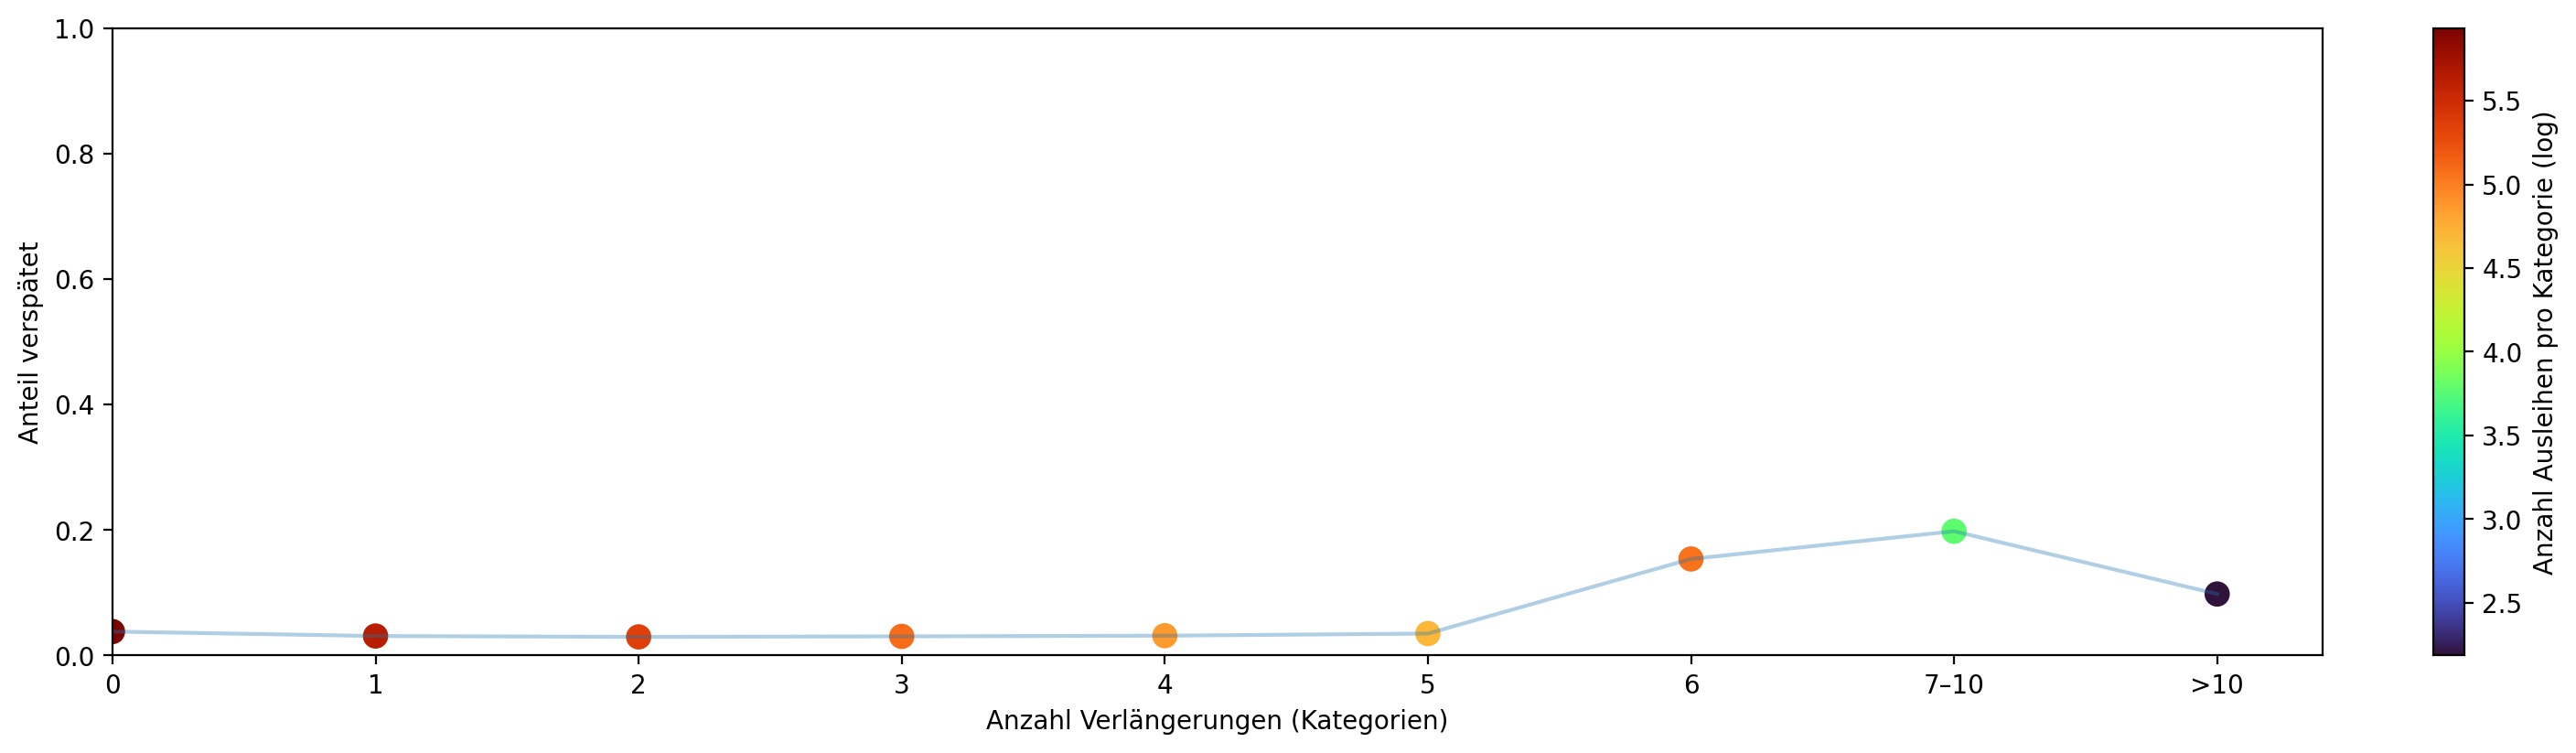

In [63]:
# look at smaller range (categories of extension from above)
categorized_extension_data = extension_data_frame.copy()

categorized_extension_data["extensions_bin"] = pd.cut(
    categorized_extension_data["Anzahl_Verlängerungen"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

late_rate_by_category = (
    categorized_extension_data.groupby("extensions_bin", observed=True)["late"]
    .agg(n="size", late_rate="mean")
    .reindex(labels)
    .reset_index()
)

x_labels = late_rate_by_category["extensions_bin"].astype(str).to_numpy()
x = late_rate_by_extensions["Anzahl_Verlängerungen"].to_numpy()
y = late_rate_by_category["late_rate"].to_numpy()
n = late_rate_by_category["n"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

c = np.log10(n)
scatter = ax.scatter(np.arange(len(x_labels)), y, c=c, s=80, cmap="turbo")
ax.plot(np.arange(len(x_labels)), y, alpha=0.35)

ax.set_xlabel("Anzahl Verlängerungen (Kategorien)")
ax.set_ylabel("Anteil verspätet")
ax.set_ylim(0, 1)
ax.set_xlim(left=0)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels)

color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label("Anzahl Ausleihen pro Kategorie (log)")

plt.show()

A closer look at the lower range of extension counts does not reveal any meaningful insights. The late-return rate appears constant, with only a small spike in segments where the number of observations is low.
One thing to note is that 6 is the maximum number of extensions allowed by the library. This likely explains the increase in late rate for the 6 and 7–10 extension categories

### Analysis across media types
But maybe there is a correlation when we look across media types. To explore this, we use a scatter plot with the percentage of loans with extensions on the x-axis and the late-return rate on the y-axis. Bubble size is proportional to the number of loans for each media type.

In [64]:
per_media_type_data = per_media_type_table.copy()

def show_per_media_type_scatter_plot(input_data_frame):
    input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())
    figure = px.scatter(
        input_data_frame,
        x="pct_with_extension",
        y="late_rate",
        size="size",
        hover_name="Medientyp",
        hover_data={
            "n_loans": True,
            "pct_with_extension": ":.2f",
            "late_rate": ":.2f",
            "size": False
        },
        labels={
            "pct_with_extension": "Percent with extension",
            "late_rate": "Late rate",
            "n_loans": "amount fo loans"
        },
        title="Extensions vs Late returns",
        trendline="ols"
    )

    figure.update_traces(marker=dict(opacity=0.75))
    figure.update_layout(
        xaxis_title="Percentage with extension (%)",
        yaxis_title="Late rate (%)",
        width=600,
        height=600,
    )

    figure.show()

show_per_media_type_scatter_plot(per_media_type_data)
log_pearson_spearman(per_media_type_data, "pct_with_extension", "late_rate")


pct_with_extension vs late_rate (n=14)
Pearson  r   = 0.8752   p-value ("null hypothesis: no correlation") = 4.15e-05
Spearman rho = 0.8242   p-value ("null hypothesis: no correlation") = = 0.000289


### MIN_BORROWINGS_PER_MEDIA_TYPE = 1000
This looks quite interesting. “Bibliothek der Dinge” stands out as a strong outlier, while the remaining media types appear to follow a fairly linear pattern. "Bibliothek der Dinge" was also an outlier in the analysis of loan duration and media types. One reason could be the fairly low sample size in comparison to other media types (1080). One idea is to increase this threshold to 5000.

### MIN_BORROWINGS_PER_MEDIA_TYPE = 5000
With a higher borrowing threshold per media type, a clear linear relationship emerges. Across media types with more than 5,000 borrowings, those with a higher share of extensions are more likely to be returned late.
This is backed by the pearson coefficient.

Correlation coefficients and p-values (null hypothesis: no correlation):
- Pearson  r   = 0.8752   p-value ("null hypothesis: no correlation") = 4.15e-05
- Spearman rho = 0.8242   p-value ("null hypothesis: no correlation") = = 0.000289

So we can see a linear relationship across media types. Media types with higher percentage of loans that get extended tend to have a higher late-return rate.

### Does the amount of extensions matter for the relationship?
Firstly, we examine the Pearson and Spearman correlation coefficients across different categories. Each category k represents the percentage of loans with a number of extensions greater than or equal to k.
Afterwards, we use a scatter plot to assess the relationship between the mean number of extensions for late loans and the late-return rate across media types

In [66]:
# look at pearson and spearman
category = [1, 2, 3, 4, 5, 6, 7, 10]

per_media_type = extension_data_frame.groupby("Medientyp").agg(
    n_loans=("issue_id", "size"),
    late_rate=("late_bool", "mean"),
).reset_index()

for k in category:
    per_media_type[f"percentage_with_extensions_>={k}"] = (
        extension_data_frame.assign(flag=extension_data_frame["Anzahl_Verlängerungen"] >= k)
        .groupby("Medientyp")["flag"].mean()
        .values
    )

# in %
per_media_type["late_rate"] *= 100
for k in category:
    per_media_type[f"percentage_with_extensions_>={k}"] *= 100

# log person per category correlations
for k in category:
    print(f"category >={k}:")
    log_pearson_spearman(per_media_type, f"percentage_with_extensions_>={k}", "late_rate")


# look at extended only, remove outliers
extended_data = extension_data_frame[
    (extension_data_frame["Anzahl_Verlängerungen"] >= 1) &
    (extension_data_frame["Anzahl_Verlängerungen"] <= 10)
    ].copy()


extended_data_properties = (
    extended_data.groupby("Medientyp")["Anzahl_Verlängerungen"]
    .agg(mean_extensions="mean", median_extensions="median", n_extenders="size")
    .reset_index()
    .sort_values("n_extenders", ascending=False)
)

plotting_data = (
    per_media_type[["Medientyp", "late_rate", "n_loans"]]
    .merge(extended_data_properties[["Medientyp", "mean_extensions", "n_extenders"]], on="Medientyp", how="left")
)

fig = px.scatter(
    plotting_data,
    x="mean_extensions",
    y="late_rate",
    size="n_loans",
    size_max=40,
    hover_name="Medientyp",
    hover_data={
        "n_loans": True,
        "n_extenders": True,
        "mean_extensions": ":.2f",
        "late_rate": ":.2f",
    },
    labels={
        "mean_extensions": "Mean # extensions (only extended loans, <=10)",
        "late_rate": "Late rate (%)",
        "n_loans": "Loans (n)",
        "n_extenders": "Extended loans (n)"
    },
    title="Late rate vs mean extensions (per media type)",
    trendline="ols"
)

fig.update_layout(width=600, height=600)
fig.show()

x = plotting_data["mean_extensions"].to_numpy()
y = plotting_data["late_rate"].to_numpy()

mask = np.isfinite(x) & np.isfinite(y)   # drop NaN/inf
pearson_r = np.corrcoef(x[mask], y[mask])[0, 1]

print(f"Pearson r (mean_extensions vs late_rate): {pearson_r:.3f}")


category: >=1
percentage_with_extensions_>=1 vs late_rate (n=14)
Pearson  r   = 0.8753   p-value ("null hypothesis: no correlation") = 4.13e-05
Spearman rho = 0.8242   p-value ("null hypothesis: no correlation") = = 0.000289
category: >=2
percentage_with_extensions_>=2 vs late_rate (n=14)
Pearson  r   = 0.9133   p-value ("null hypothesis: no correlation") = 5.07e-06
Spearman rho = 0.8989   p-value ("null hypothesis: no correlation") = = 1.24e-05
category: >=3
percentage_with_extensions_>=3 vs late_rate (n=14)
Pearson  r   = 0.8929   p-value ("null hypothesis: no correlation") = 1.72e-05
Spearman rho = 0.8945   p-value ("null hypothesis: no correlation") = = 1.58e-05
category: >=4
percentage_with_extensions_>=4 vs late_rate (n=14)
Pearson  r   = 0.8685   p-value ("null hypothesis: no correlation") = 5.6e-05
Spearman rho = 0.8901   p-value ("null hypothesis: no correlation") = = 2e-05
category: >=5
percentage_with_extensions_>=5 vs late_rate (n=14)
Pearson  r   = 0.8522   p-value ("null 

Pearson r (mean_extensions vs late_rate): 0.800


## Summary
Across media types, higher late-return rates are strongly associated with more extension activity. This relationship is consistent across multiple thresholds k (share of loans with ≥ k extensions), suggesting that it is driven by overall “renewal heaviness” rather than any specific cutoff. In other words, the exact number of extensions used to define the categories matters less than the general prevalence of repeated extensions within a media type